# IBM Quantum challenge 2021 part 3: image classification

**Goal**: Implement a 3-class classifier using QSVM and achieve 70% accuracy on clothing image dataset with smaller feature map circuits.

**Dataset**: Fashion-MNIST clothing image dataset.

**Realization**: the idea is to use three one-vs-all SVM classification. The kernel will be a quantum part of this algorithm.

The conditions are in the [notebook on the challenge page](https://github.com/qiskit-community/ibm-quantum-challenge-fall-2021/blob/main/content/challenge-3/challenge-3.ipynb). The data I use can be downloaded [here](https://github.com/qiskit-community/ibm-quantum-challenge-fall-2021/blob/main/content/challenge-3/resources/ch3_part2.npz) or just imported from ready datasets.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from tqdm import tqdm

# scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Qiskit imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel

# Load the data

label 0: T-shirt/top

label 2: pullover

label 3: dress

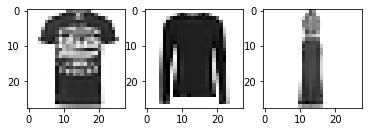

In [2]:
# Load MNIST dataset from the challenge
DATA_PATH = './resources/ch3_part2.npz'
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']
sample_test = data['sample_test']

# Split train data
sample_train, sample_val, labels_train, labels_val = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

# Visualize samples
fig = plt.figure()

LABELS = [0, 2, 3]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

In [3]:
# Standardize
standard_scaler = StandardScaler()
sample_train = standard_scaler.fit_transform(sample_train)
sample_val = standard_scaler.transform(sample_val)
sample_test = standard_scaler.transform(sample_test)

# Reduce dimensions: we can't simulate/access 28^2 qubits, and it's not even necessary
N_DIM = 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
sample_test = pca.transform(sample_test)

# Normalize
min_max_scaler = MinMaxScaler((-1, 1))
sample_train = min_max_scaler.fit_transform(sample_train)
sample_val = min_max_scaler.transform(sample_val)
sample_test = min_max_scaler.transform(sample_test)

In [4]:
def find_labels(label, labels_train, labels_test):
    '''
    Transform labels into 0 and 1
    '''
    labels_train_oh = np.where(labels_train==label, 1, 0)
    labels_val_oh = np.where(labels_val==label, 1, 0)
    return labels_train_oh, labels_val_oh

labels = {}
labels['train'] = {}
labels['val'] = {}

#print(f'Original validation labels:      {labels_val}')
for i in [0,2,3]:
    labels['train'][i], labels['val'][i] = find_labels(i, labels_train, labels_val)
    #print(f'Validation labels for 0 vs Rest: {labels['val'][i]}')

# SVM

Classification is basically separating different classes by a border in a feature space. One way to establish the border is to calculate "distances" between all the labelled points and a new one. Such distance can be expressed as a kernel $k(x,y)$.


# Quantum kernel

This is the quantum part of the study.

## Quantum feature map

Let's see how one encodes classical features $\mathbf{x}$ on quantum states of $n$ qubits. We use a feature map $\Phi(\mathbf{x})$ from a classical feature $\mathbf{x}$ to a quantum state $|\Phi(\mathbf{x})\rangle = \mathcal{U}_{\Phi(\mathbf{x})}|0\rangle^n$.

The general one is **Pauli map** using Hadamard gates $H$ and Pauli gates $P_i \in \{ I, X, Y, Z \}$:

$\mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_i\right),$

where $S \in \{\binom{n}{k}\ combinations,\ k = 1,... n \}$ describes connections between data points, and the data mapping function writes:

$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$
    
Partial cases are Z-map (using $Z$ Pauli operator) and ZZ-map (using $Z$ and $ZZ$).


## Quantum kernel

The kernel can be expressed via feature maps.
$K(x_i, x_j) = \left| \langle 0^{\otimes n} | \mathcal{U}^\dagger_{\Phi(\mathbf{x}_j)} \mathcal{U}_{\Phi(\mathbf{x_i})} | 0^{\otimes n} \rangle \right|^{2}$.

It can be interpreted as a probability to end up in the vacuum state after applying unitary transformations $\mathcal{U}^\dagger_{\Phi(\mathbf{x}_j)}$ and $\mathcal{U}_{\Phi(\mathbf{x_i})}$ on a vacuum state. And thus we can actually caculate them experimentally.

In [5]:
# try zz map
def zz_score(dim, sample_train, sample_val, labels_train_0, labels_val_0, reps = 2, entanglement='circular', verbose = False):
    '''
    Using zz-map to construct a SVM kernel.
    
        
    '''
    zz_map_0 = ZZFeatureMap(feature_dimension=dim, reps=reps, entanglement=entanglement)
    zz_kernel_0 = QuantumKernel(feature_map=zz_map_0, quantum_instance=Aer.get_backend('statevector_simulator'))

    zz_svc_0 = SVC(kernel='precomputed', probability=True)

    matrix_train_0 = zz_kernel_0.evaluate(x_vec=sample_train)
    zz_svc_0.fit(matrix_train_0, labels_train_0)

    matrix_val_0 = zz_kernel_0.evaluate(x_vec=sample_val, y_vec=sample_train)
    pauli_score_0 = zz_svc_0.score(matrix_val_0, labels_val_0)
    if verbose:
        print(f'Accuracy of discriminating between this label and others: {pauli_score_0*100}%')
    
    return zz_svc_0, zz_kernel_0, pauli_score_0*100


In [6]:
# grid search

best_params = {}
for label in tqdm([0, 2, 3]):
    best_score = 0
    for entanglement in ['circular', 'linear', 'full']:
        for rep in [1,2,3]:
            _, __, score = zz_score(N_DIM, sample_train, sample_val, labels['train'][label], labels['val'][label],
                                     entanglement = entanglement, reps = rep)
            if score > best_score:
                best_score = score
                best_params[label] = {'entanglement':entanglement, 'reps': rep}
    print(best_score, best_params[label])

 33%|███▎      | 1/3 [00:25<00:51, 25.72s/it]

95.0 {'entanglement': 'linear', 'reps': 1}


 67%|██████▋   | 2/3 [00:49<00:24, 24.44s/it]

95.0 {'entanglement': 'full', 'reps': 1}


100%|██████████| 3/3 [01:12<00:00, 24.24s/it]

95.0 {'entanglement': 'linear', 'reps': 1}


In [7]:
# evaluation

zz_svc = {}
zz_kernel = {}

matrix_test_zz = {}
pred = {}


for label in [0, 2, 3]:
    zz_svc[label], zz_kernel[label], score = zz_score(N_DIM, sample_train, sample_val,
                                                      labels['train'][label],
                                                      labels['val'][label],
                                                      **best_params[label],
                                                      verbose = True)
    
    matrix_test_zz[label] = zz_kernel[label].evaluate(x_vec = sample_test, y_vec = sample_train)
    pred[label] = zz_svc[label].predict_proba(matrix_test_zz[label])[:,1]

Accuracy of discriminating between this label and others: 95.0%
Accuracy of discriminating between this label and others: 95.0%
Accuracy of discriminating between this label and others: 95.0%


In [8]:
pred_test = np.where((pred[0] > pred[2]) & (pred[0] > pred[3]), 
                      0, np.where(pred[2] > pred[3], 2, 3))

In [9]:
print(f'Prediction: {pred_test}')

Prediction: [0 0 3 3 3 3 0 0 0 0 3 2 2 0 3 2 3 0 3 2]


In [10]:
# there is no data on the labes in the set, so i used my eyes
tst_l = [0, 0, 3, 3, 3, 3, 0, 2, 0, 0, 3, 0, 2, 0, 3, 2, 3, 0, 3, 0]

In [11]:
(tst_l == pred_test).sum(), (tst_l != pred_test).sum()

(17, 3)

In [12]:
print(f'Accuracy: {(tst_l == pred_test).mean()}')

Accuracy: 0.85


85% is not great, but better than 70% required in the challenge condition. Let's see what was missclassified:

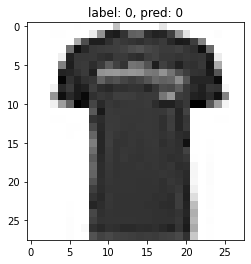

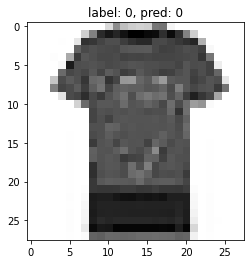

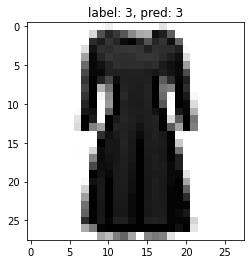

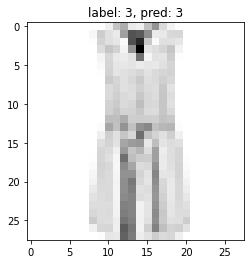

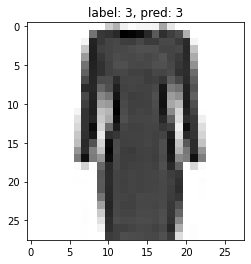

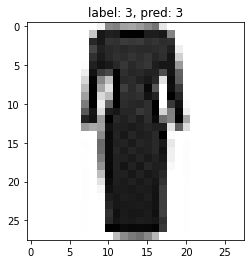

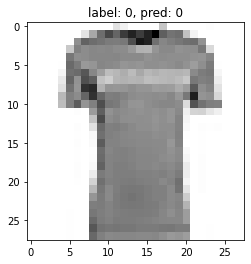

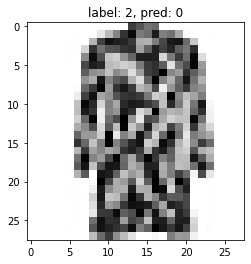

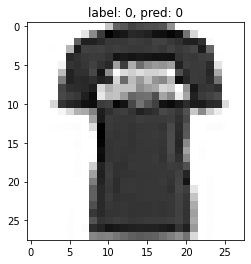

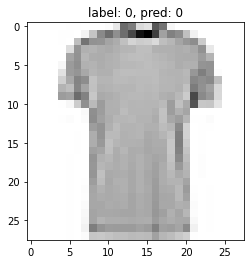

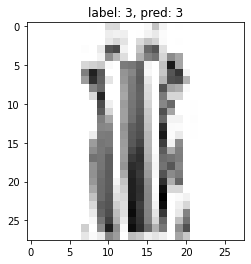

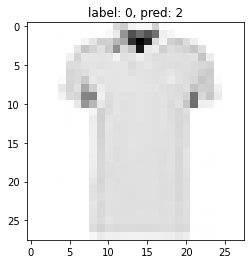

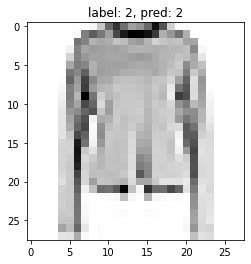

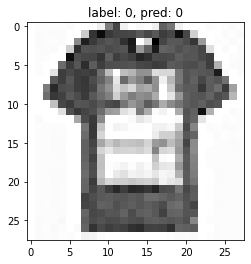

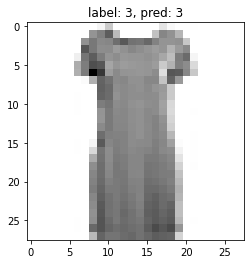

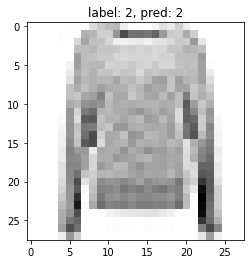

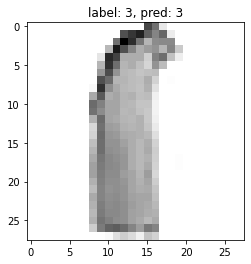

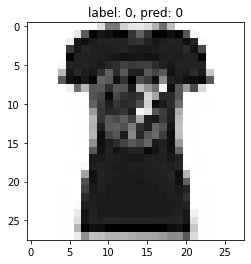

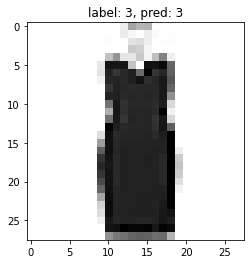

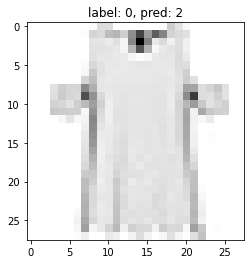

In [13]:
for i, d in enumerate(data['sample_test']):
    fig = plt.figure()
    img = d.reshape((28, 28))
    plt.imshow(img, cmap="Greys")
    plt.title(f'label: {tst_l[i]}, pred: {pred_test[i]}')

In [14]:
for classical_kernel in ['poly', 'linear', 'sigmoid', 'rbf']:
    classical_svc = SVC(kernel = classical_kernel)
    classical_svc.fit(sample_train, labels_train)
    classical_score = classical_svc.score(sample_test, tst_l)
    print(classical_kernel, classical_score)

poly 0.95
linear 0.9
sigmoid 1.0
rbf 0.85


**conclusion**:
Quantum does not mean better